# Calculate the AIA emissivities in each MURaM voxel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from scipy.io import readsav
from scipy.interpolate import griddata
import sunpy.visualization.colormaps as cm

work_dir = 'C:/Users/MoVEV/Documents/GitHub/VR_MHD/'

plot_dir = work_dir + 'Plots/'

data_dir = work_dir + 'MURaM_cubes/Flare/'

cmap_94 = cm.cm.sdoaia94
cmap_131 = cm.cm.sdoaia131
cmap_171 = cm.cm.sdoaia171
cmap_193 = cm.cm.sdoaia193
cmap_211 = cm.cm.sdoaia211
cmap_335 = cm.cm.sdoaia335
cmap_304 = cm.cm.sdoaia304

aia_wavs = ['94', '131', '171', '193', '211', '335', '304']
aia_cmaps = [cmap_94, cmap_131, cmap_171, cmap_193, cmap_211, cmap_335, cmap_304]

# Calculate a temperature response function (TRF) to apply to the data cubes

## Define a custom TRF

In [2]:
# Define density and temperature grids 
dens_trf = 10**np.arange(5,15,0.5)  # Electron density grid 
temp_trf = 10**np.arange(5,7.6,0.1) # Electron temperature grid

def gaussian_trf(x,y,a,Tc,sigma):
    """
    Define a custom TRF that uses a 1-D gaussian centered on a particular temperature.
    This TRF is closer to what I think Matthias used to produce the original datacube
    of emissivities that you worked with.

    The function does not depend on density but we leave open the possibility that it could be
    a function of density.
    """
    return a * np.exp(-(x-Tc)**2/(2*sigma**2))#*np.log10(y)

# Calculate the 2D temperature/density response function.
xx,yy = np.meshgrid(temp_trf,dens_trf)
test_trf = gaussian_trf(xx, yy, 1, 1.e6, 1.e5)

print('Temperature grid shape: ', temp_trf.shape)
print('Density grid shape: ', dens_trf.shape)
print('TRF grid shape: ', test_trf.shape)

Temperature grid shape:  (26,)
Density grid shape:  (20,)
TRF grid shape:  (20, 26)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
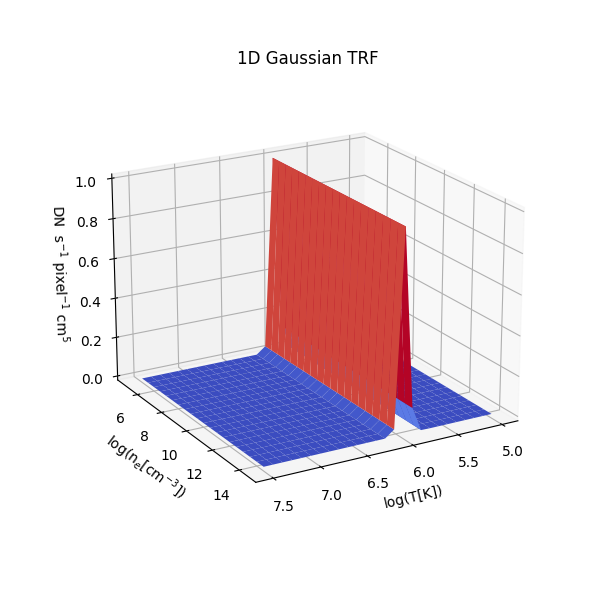

In [3]:
%matplotlib widget

image_display = plt.figure(figsize=[6, 6], dpi=100)

ax = image_display.add_subplot(1,1,1, projection='3d')

ax.plot_surface(np.log10(xx), np.log10(yy), test_trf, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('log(T[K])')
ax.set_ylabel('log(n$_{e}$[cm$^{-3}$])')
ax.set_zlabel('DN  s$^{-1}$ pixel$^{-1}$ cm$^{5}$')
ax.set_title('1D Gaussian TRF')
    
ax.view_init(20, 60)

## Load TRFs for each AIA EUV channel

In [4]:
# Load the grids of AIA temperature response functions.
# These were computed using the gd_aia_response.pro IDL routine.
# It requires the CHIANTI atomic database to work. (https://www.chiantidatabase.org/)
# It's not critical at the moment that you should install or learn more about CHIANTI.

sav_data = readsav(work_dir + 'aia_resp_grid.sav', python_dict=False)

# Density array with N=20 entries
dens_trf = sav_data['aia_resp_grid'][0]['dens'] 
# Contains a series of N=20 TRFs, each computed for each density
aia_resp_all = sav_data['aia_resp_grid'][0]['aia_resp_all']  

temp_trf = aia_resp_all[0]['temperatures'] # Temperature array for computing each TRF
aia_resp_trf = np.zeros([6, dens_trf.shape[0], temp_trf.shape[0]])

for i in range(dens_trf.shape[0]):
    aia_resp_trf[0,i,:] = aia_resp_all[i]['resp_94']
    aia_resp_trf[1,i,:] = aia_resp_all[i]['resp_131']
    aia_resp_trf[2,i,:] = aia_resp_all[i]['resp_171']
    aia_resp_trf[3,i,:] = aia_resp_all[i]['resp_193']
    aia_resp_trf[4,i,:] = aia_resp_all[i]['resp_211']
    aia_resp_trf[5,i,:] = aia_resp_all[i]['resp_335']
    
print('Temperature grid shape: ', temp_trf.shape)
print('Density grid shape: ', dens_trf.shape)
print('TRF grid shape: ', aia_resp_trf.shape)

Temperature grid shape:  (26,)
Density grid shape:  (20,)
TRF grid shape:  (6, 20, 26)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
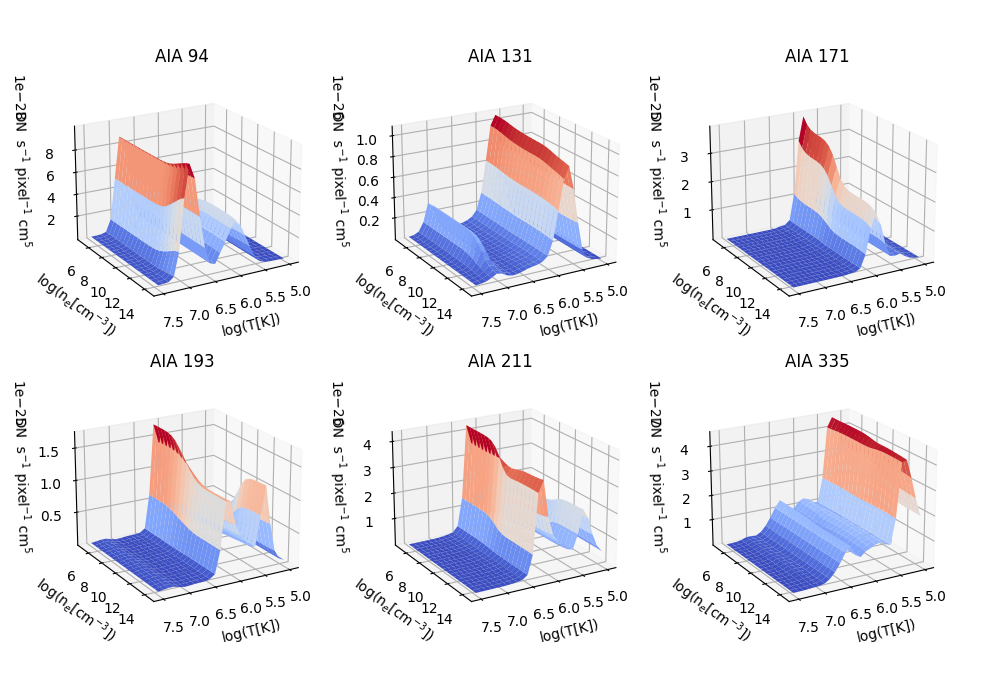

In [5]:
# Plot the TRFs for each AIA channel.
# It is noticeable that the TRFs are strong functions of temperature but much weaker functions of 
# density. However, some of the channels (e.g. 171) do show larger variations with density. 

%matplotlib widget

#image_display, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=False, figsize=[7, 10], dpi=100)         
image_display = plt.figure(figsize=[10, 7], dpi=100)

ax = []
for i in range(6):
    ax.append(image_display.add_subplot(2,3,i+1, projection='3d'))

image_display.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95,                               
                              wspace=0.2, hspace=0.2) 
    
filters = ['AIA 94', 'AIA 131', 'AIA 171', 'AIA 193', 'AIA 211', 'AIA 335']

xx,yy = np.meshgrid(temp_trf,dens_trf)
for i in range(6):
    f = aia_resp_trf[i,:,:]  # Select the function to plot.
    surf = ax[i].plot_surface(np.log10(xx), np.log10(yy), f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax[i].set_xlabel('log(T[K])')
    ax[i].set_ylabel('log(n$_{e}$[cm$^{-3}$])')
    ax[i].set_zlabel('DN  s$^{-1}$ pixel$^{-1}$ cm$^{5}$')
    ax[i].set_title(filters[i])
    #image_display.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
    ax[i].view_init(20, 60)

In [6]:

# Create the interpolated function and calculate it at the desired densities/temperatures.

f = aia_resp_trf[2,:,:] # Load a 2D density x temperature temperature response function.

grid_custom = np.asarray([[7,6.1], [7.2,6.1], [8,6.4], [9, 5.9]])  # Find data at these custom points.

xxx,yyy = np.meshgrid(np.log10(dens_trf),np.log10(temp_trf))  # Reform the density and temperature arrays.
dens_temp = np.asarray([xxx.flatten(), yyy.flatten()]).transpose()

grid_test = griddata(dens_temp, f.flatten(), grid_custom, method='cubic')  # Find the interpolated values.
# I should be able to replace grid_custom = (density(x,y,z), temperature(x,y,z)) and the result with be in (x,y,z)
# which is the shape of the data cubes.



## Online example for using the griddata function

This section is not used for computing the emissivities.

In [7]:
# Online example for using the griddata function

def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:50j, 0:1:50j]
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:,0], points[:,1])
from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

#grid_custom = np.asarray([[0.2,0.5], [0.3,0.7], [0.2,0.2], [0.8, 0.9]])
grid_custom = rng.random((300,2))
grid_z3 = griddata(points, values, grid_custom, method='cubic')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
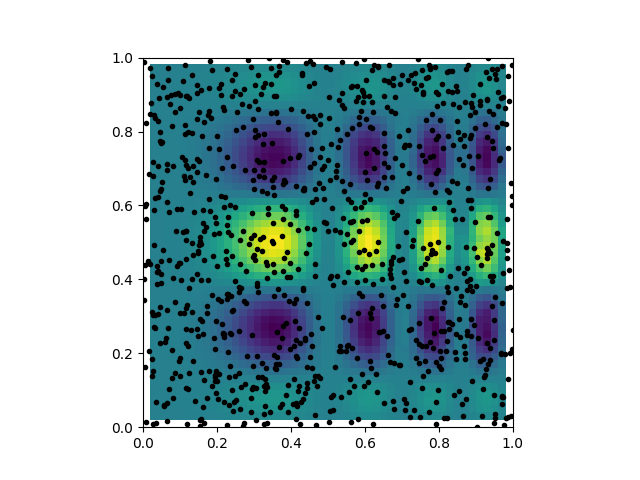

In [8]:
%matplotlib widget

plt.imshow(grid_z2, origin='lower', extent=[0,1,0,1])
plt.plot(points[:,0], points[:,1], 'k.')

C:\Users\MoVEV\AppData\Local\Temp/ipykernel_4580/2438250078.py:5: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(grid_x, grid_y, grid_z2, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none', alpha=0.2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
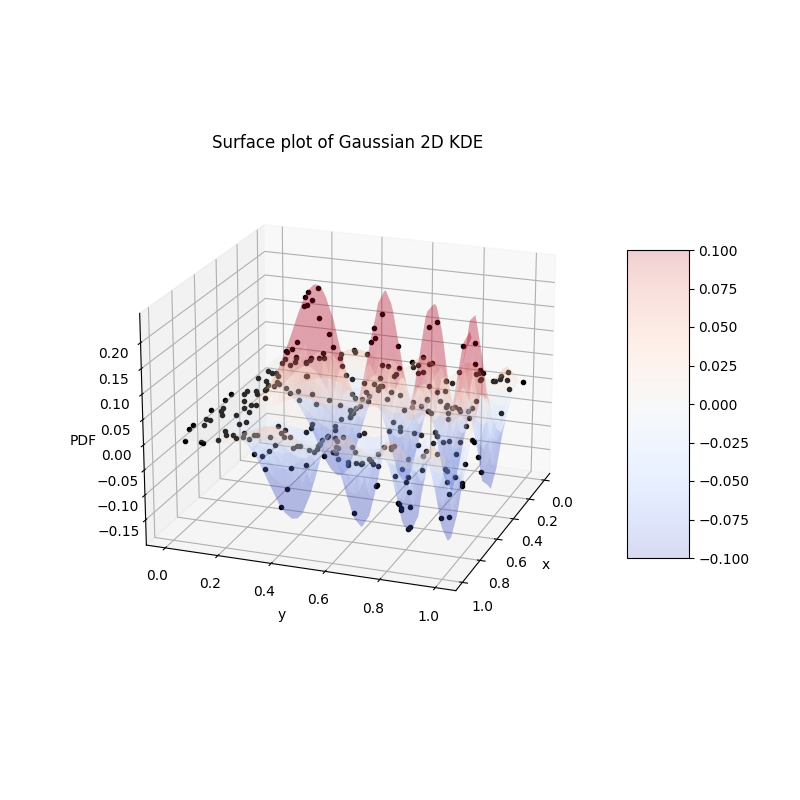

In [9]:
%matplotlib widget

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z2, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none', alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(20, 20)

ax.plot(grid_custom[:,0], grid_custom[:,1], grid_z3, 'k.')

# Load the MURaM data cubes

In [10]:
# Helper functions adapted from the file muram_io.py which is included with the 
# data distribution.

def inttostring(ii,ts_size=7):
    str_num = str(ii)
    for bb in range(len(str_num),ts_size,1):
        str_num = '0'+str_num
    
    return str_num

def read_var_3d(dir,var,iter):
    """
    The data collection for the Flare simulation does not include a
    Header type file so the simulation details are hard-coded.
    dir: directory where the binary data files are located
    var: physical variant of interest (examples listed below)
        eosT ; Temperature in K
        eosP ; Pressure in dyne/cm^2
        result_prim_0 ; density in g/cm^3
        result_prim_1 ; vx in cm/s
        result_prim_3 ; vy in cm/s
        result_prim_2 ; vz in cm/s !VERTICAL!
        result_prim_4 ; uint in erg/cm^3
        result_prim_5 *sqrt(4*!PI)  ;bx in G
        result_prim_7 *sqrt(4*!PI)  ;by in G
        result_prim_6 *sqrt(4*!PI)  ;bz in G 
    iter: simulation iteration step. e.g 270000, 292000
    """
             
    size = [512,768,256]  # Shape of the data stored inside the binary files. (nx,nz,ny)
    dx = [192e5, 192e5, 64e5] # x,y,z scaling dimensions in [cm]
    
    # Axes scaled to [cm]
    x = np.arange(size[0])*dx[0] - 49.156e8  
    y = np.arange(size[2])*dx[1] - 24.576e8
    z = np.arange(size[1])*dx[2] - 7.5e8
    
    # Load the data from the files.
    tmp = np.fromfile(dir+var+'.'+ inttostring(iter,ts_size=7),dtype=np.float32)
    tmp = tmp.reshape([size[2],size[1],size[0]]) # Python reads the arrays in reverse order
    
    # Re-arrange the data from [y,z,x] ==> [x,y,z] 
    tmp = tmp.transpose([2,0,1])  
    
    return tmp,dx,size,x,y,z

In [20]:
# Load the physical data from the MURaM binary files.
sc = 1.e-8 # Scaling factor to convert axes to Mm
temp,dx,size,x,y,z = read_var_3d(data_dir, 'eosT', 270000)  # Temperature in K
#pres,dx,size,x,y,z = read_var_3d(data_dir, 'eosP', 270000)
#rho,dx,size,x,y,z = read_var_3d(data_dir, 'result_prim_0', 270000) # Mass density

# Calculate the electron density assuming the ideal gas law.
#1.913 * P = n_ekT
kb = 1.380649e-16
dens = 1.913 * pres/(temp * kb) # Electron density in cm^-3

# Alternatively the mean number density of protons 
# can be calculated by dividing the mean mass density by the proton mass mp = 1.67e-24 g
#mp = 1.57e-24
#rho1 = rho/mp

# The simulation has density values log10(ne[cm^-3]) > 15 below the surface of the Sun (photosphere)
# Threshold the density since my response function grid only covers 5<log(ne)<15 
dens[np.log10(dens) > 15] = 10**15.0
dens[np.log10(dens) < 5] = 10**5


In [22]:
print(temp)

[[[  49419.414   48955.984   48500.453 ... 3891712.5   4048542.2
   4139423.   ]
  [  49418.34    48955.4     48502.47  ... 3945702.5   4085453.5
   4164446.5  ]
  [  49416.016   48956.434   48502.766 ... 3990803.    4112462.5
   4178512.2  ]
  ...
  [  49415.676   48953.668   48498.14  ... 3708799.5   3893095.
   4008444.   ]
  [  49417.953   48956.36    48499.59  ... 3770947.8   3950761.5
   4059825.8  ]
  [  49418.49    48956.35    48499.34  ... 3832477.8   4003167.2
   4104132.8  ]]

 [[  49417.23    48955.773   48502.37  ... 3808281.    3978019.
   4078689.2  ]
  [  49416.14    48956.68    48506.2   ... 3862062.    4017671.2
   4107359.   ]
  [  49416.652   48958.76    48507.906 ... 3908866.2   4048785.
   4127166.   ]
  ...
  [  49417.574   48954.645   48497.34  ... 3633702.    3820349.8
   3941999.8  ]
  [  49418.42    48956.082   48498.977 ... 3692033.    3876688.
   3994095.5  ]
  [  49417.434   48955.258   48499.414 ... 3750744.    3929863.5
   4040245.   ]]

 [[  49414.902  

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
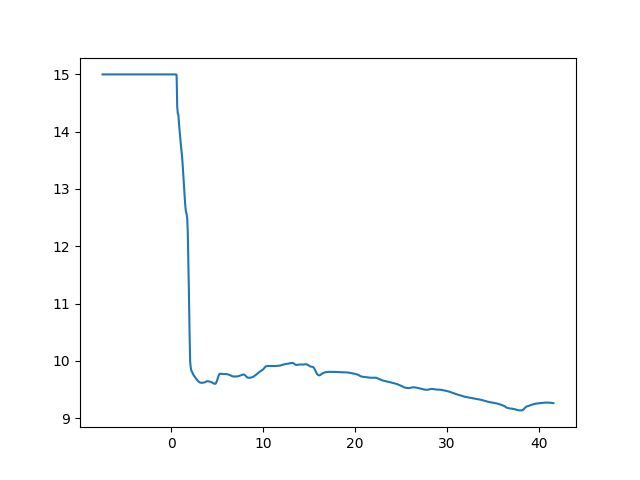

In [12]:
# Plot the density and temperature 1D profiles
%matplotlib widget

plt.plot(z*sc, np.log10(dens[200,200,:]))
plt.show()
#plt.plot(z*sc, np.log10(rho1[200,200,:]))

#plt.ylim(5,15)


Text(0, 0.5, 'z [Mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
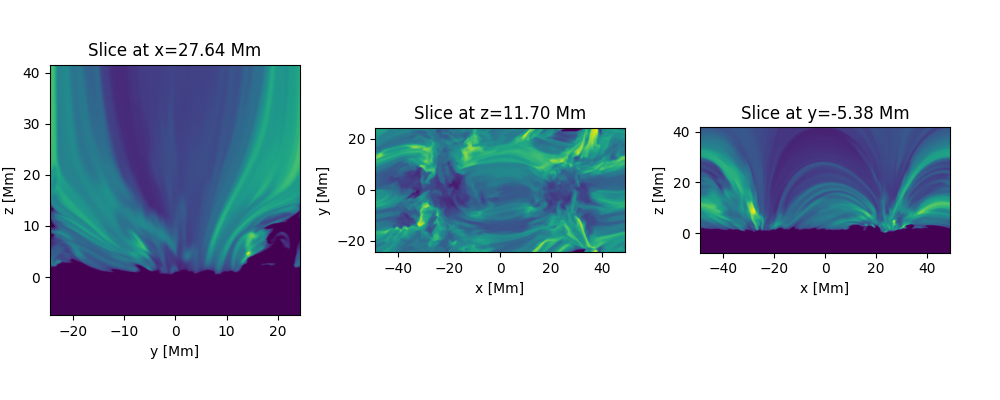

In [13]:
# Plot some slices through the data array as a test.

%matplotlib widget

image_display, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,4], dpi=100)
image_display.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,                               
                              wspace=0.3, hspace=0.2) 

# Choose which of the data arrays to plot.
testarr = temp

# Slice in the y-z plane
xin = 400
ax[0].imshow(testarr[xin,:,:].transpose(), origin='lower', extent=[y[0]*sc, y[-1]*sc, z[0]*sc, z[-1]*sc],
            aspect='equal')
ax[0].set_title('Slice at x={0:4.2f} Mm'.format(x[xin]*sc))
ax[0].set_xlabel('y [Mm]')
ax[0].set_ylabel('z [Mm]')

# Slice in the x-y plane at some height z
zin = 300
ax[1].imshow(testarr[:,:,zin].transpose(), origin='lower', extent=[x[0]*sc, x[-1]*sc, y[0]*sc, y[-1]*sc],
            aspect='equal')

ax[1].set_title('Slice at z={0:4.2f} Mm'.format(z[zin]*sc))
ax[1].set_xlabel('x [Mm]')
ax[1].set_ylabel('y [Mm]')

# Slice in the x-z plane
yin = 100
ax[2].imshow(testarr[:,yin,:].transpose(), origin='lower', extent=[x[0]*sc, x[-1]*sc, z[0]*sc, z[-1]*sc], 
                aspect='equal')
ax[2].set_title('Slice at y={0:4.2f} Mm'.format(y[yin]*sc))
ax[2].set_xlabel('x [Mm]')
ax[2].set_ylabel('z [Mm]')

# Calculate the emission in each voxel for a given TRF

In [14]:
# Create the interpolated function and calculate it at the desired densities/temperatures.

### Need to first select which TRF will be used ###
# Use the AIA TRF.
aia_ch = 2  # Choose the AIA channel
trf = aia_resp_trf[aia_ch,:,:]

# Use a custom TRF
#trf = test_trf

### Calculate the interpolated TRF values at the model densities and temperatures ###
tstart = time.time()

# Reform the density and temperature arrays.
xxx,yyy = np.meshgrid(np.log10(dens_trf),np.log10(temp_trf))  
dens_temp = np.asarray([xxx.flatten(), yyy.flatten()]).transpose()

# Compute the TRF values at the density/temperature datapoints through cubic interpolation.
grid_test = griddata(dens_temp, f.flatten(), (np.log10(dens), np.log10(temp)), method='cubic', fill_value=0.0) 

# At low values the interpolation oscillates giving negative values.
grid_test[grid_test < 0.0] = 0.0
# Fine any NaN values 
grid_test[np.isnan(grid_test)] = 0.0

### Calculate the emissivity ###
cube_emiss = grid_test * dens**2

print('Runtime: {0:4.1f}'.format(time.time() - tstart))
print('Calculated emissivity data cube of shape: ', cube_emiss.shape)

Runtime: 30.2
Calculated emissivity data cube of shape:  (512, 256, 768)


In [15]:
cube_emiss.shape

(512, 256, 768)

C:\Users\MoVEV\AppData\Local\Temp/ipykernel_4580/18337393.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("SDO AIA 171.0 Angstrom").copy()
  aia_cmaps[aia_ch].set_bad(color='red')  # Set the NaN values to be shown with red.


Text(0, 0.5, 'z [Mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
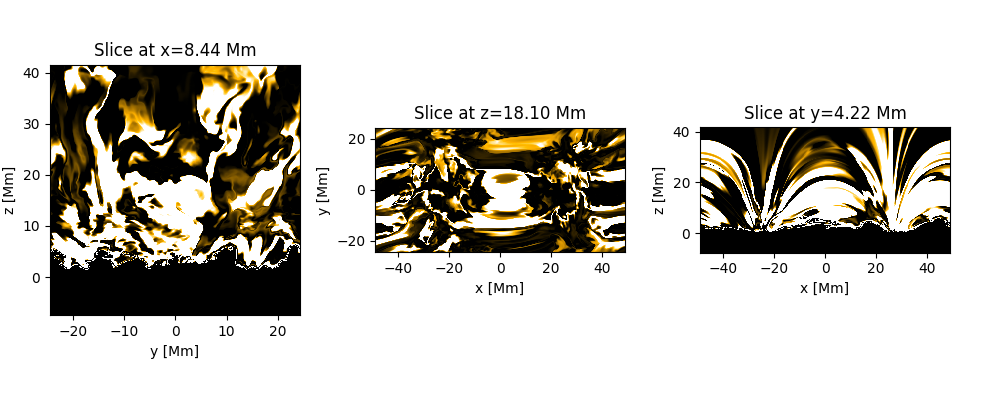

In [16]:
# Plot some slices through the data array as a test.

%matplotlib widget

image_display, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,4], dpi=100)
image_display.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,                               
                              wspace=0.3, hspace=0.2) 

# Select the emissivity data to plot.
# I multiply by 1.e-22 to normalize the weird small values. 
# Still working on a nice way to normalize the data to it's easier to work with.
# This is 
testarr = cube_emiss #* 1.e-22


aia_cmaps[aia_ch].set_bad(color='red')  # Set the NaN values to be shown with red.

# Slice in the y-z plane
xin = 300
tt = ax[0].imshow(testarr[xin,:,:].transpose()*dx[0], origin='lower', extent=[y[0]*sc, y[-1]*sc, z[0]*sc, z[-1]*sc],
            aspect='equal', cmap=aia_cmaps[aia_ch], interpolation='none', vmin=0, vmax=10)
ax[0].set_title('Slice at x={0:4.2f} Mm'.format(x[xin]*sc))
ax[0].set_xlabel('y [Mm]')
ax[0].set_ylabel('z [Mm]')

# Slice in the x-y plane at some height z
zin = 400
ax[1].imshow(testarr[:,:,zin].transpose()*dx[2], origin='lower', extent=[x[0]*sc, x[-1]*sc, y[0]*sc, y[-1]*sc],
            aspect='equal', cmap=aia_cmaps[aia_ch], interpolation='none', vmin=0, vmax=10)

ax[1].set_title('Slice at z={0:4.2f} Mm'.format(z[zin]*sc))
ax[1].set_xlabel('x [Mm]')
ax[1].set_ylabel('y [Mm]')

# Slice in the x-z plane
yin = 150
ax[2].imshow(testarr[:,yin,:].transpose()*dx[1], origin='lower', extent=[x[0]*sc, x[-1]*sc, z[0]*sc, z[-1]*sc], 
                aspect='equal', cmap=aia_cmaps[aia_ch], interpolation='none', vmin=0, vmax=10)
ax[2].set_title('Slice at y={0:4.2f} Mm'.format(y[yin]*sc))
ax[2].set_xlabel('x [Mm]')
ax[2].set_ylabel('z [Mm]')

In [17]:

plt.plot(grid_test[300,100,:]*1.e19)
plt.plot(cube_emiss[300,100,:])
